In [2]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.externals import joblib

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.objectives import binary_crossentropy, mse
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)
%matplotlib inline

Using TensorFlow backend.


## Read data

In [3]:
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests

df = pd.read_csv('../../Data/LHCb_PID_obscured.csv')
df.head()

,pid,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,...,S4x1,S4x2,S3x2,S4x3,S4x4,S5x1,S5x2,S5x3,S5x4,S4x5
0,a,1.0,1.0,1.0,12.470869,16.0,1.498864,4.0,0.0,0.0,...,43124.0,1.0,4497.850098,1696.200195,0.195356,1.046679,538.357971,35546.0,1.0,655.779785
1,f,1.0,-999.0,-999.0,2.611352,6.0,8.613868,9.0,-999.0,-999.0,...,-999.0,-999.0,-999.000000,-999.000000,-999.000000,0.942609,745.686462,35684.0,0.0,-999.000000
2,c,1.0,1.0,1.0,15.694536,17.0,5.911904,7.0,1.0,1.0,...,35553.0,1.0,566.271973,1401.664062,0.538877,0.841611,811.178467,35799.0,0.0,-2616.123047
3,d,-999.0,1.0,1.0,12.244493,14.0,2.455816,3.0,0.0,0.0,...,39028.0,1.0,4894.333984,85.869995,1.656766,-999.000000,-999.000000,-999.0,-999.0,230.555283
4,c,1.0,-999.0,-999.0,22.676029,19.0,4.777353,5.0,-999.0,-999.0,...,-999.0,-999.0,-999.000000,-999.000000,-999.000000,0.968089,1529.644287,34142.0,1.0,-999.000000


In [4]:
# How many samples of each particle we have
print(df['pid'].value_counts())

d    545384
b    545384
a    545384
f    545384
c    545384
e    545384
Name: pid, dtype: int64


In [5]:
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [6]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

35 variables to compress


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 3min 26s, sys: 14.1 s, total: 3min 40s
Wall time: 15.6 s


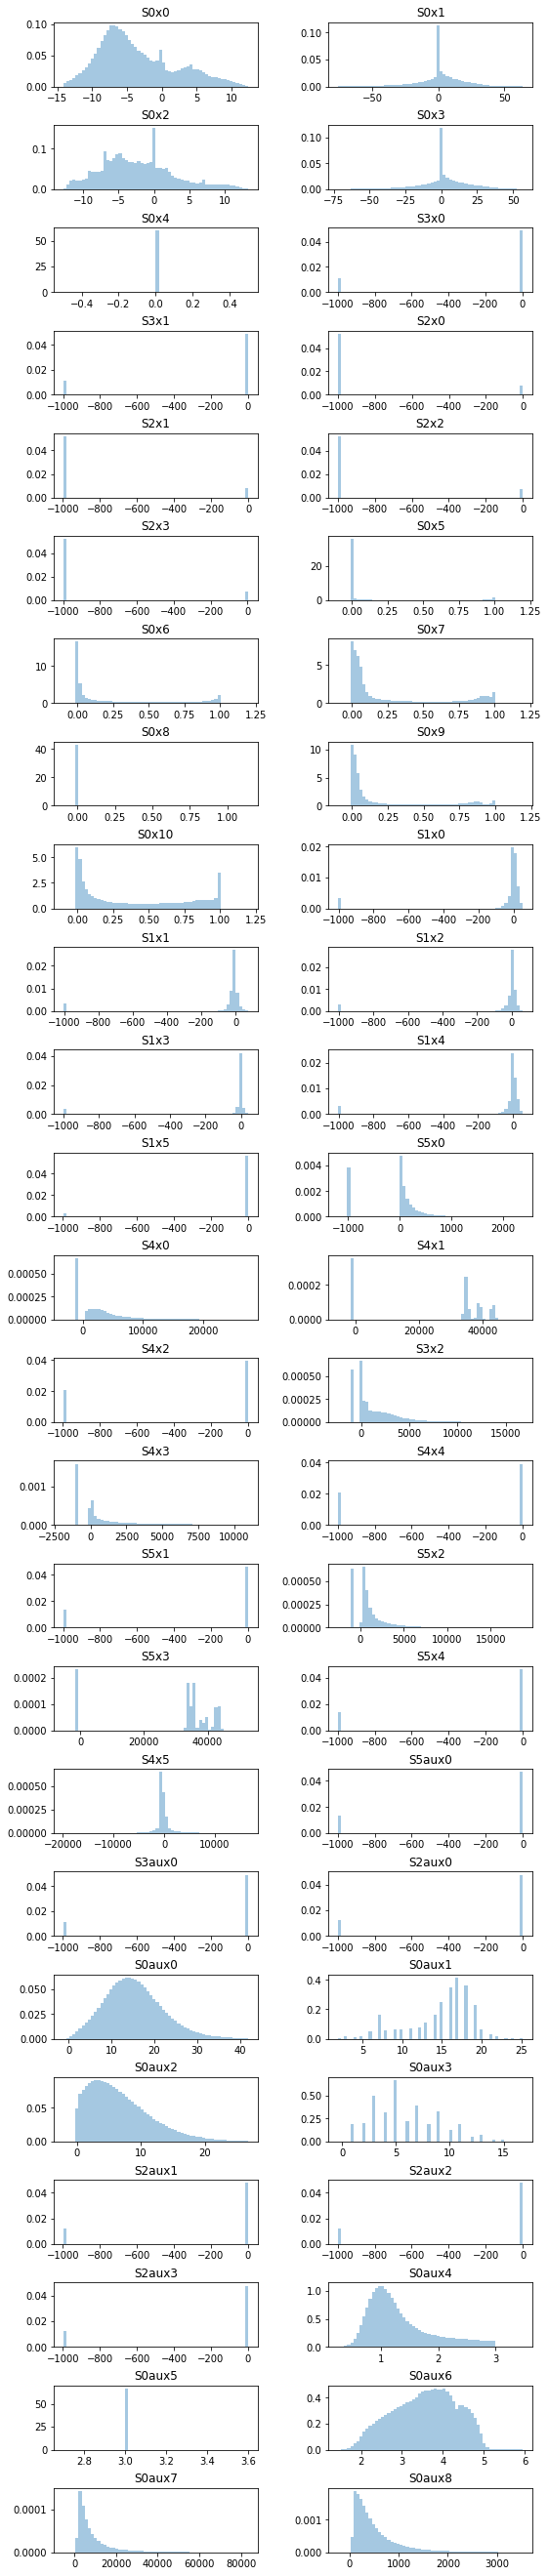

In [9]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./img/original_distribs.png")

# train-test split

In [10]:
XGB_TRAIN_SIZE = 0.1
AE_TRAIN_SIZE = 0.5

In [19]:
# CLASSIFIER train test split
xgb_size = XGB_TRAIN_SIZE
data_size = 1 - XGB_TRAIN_SIZE
idx_xgb, idx_data = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=xgb_size, test_size=data_size)

xgb_data = df.iloc[idx_xgb]
df = df.iloc[idx_data]

xgb_data.to_csv("./csv/xgb_train_data.csv")

In [31]:
# train test split
train_size = AE_TRAIN_SIZE
test_size = 1 - AE_TRAIN_SIZE
idx_train, idx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=train_size, test_size=test_size)

train = df.iloc[idx_train]
test = df.iloc[idx_test]

train.to_csv("csv/vae_train.csv")
test.to_csv("csv/vae_test.csv")

## features scaling

In [32]:
train_scaled = train.copy()
test_scaled = test.copy()

In [33]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
#     # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(train[var].values.reshape(-1, 1))
    train_scaled[var] = std_scaler.transform(train[var].values.reshape(-1, 1))
    test_scaled[var] = std_scaler.transform(test[var].values.reshape(-1, 1))
    
    # normalize with MaxAbsScaler
    max_scaler = MinMaxScaler()
    max_scaler.fit(train_scaled[var].values.reshape(-1, 1))
    train_scaled[var] = max_scaler.transform(train_scaled[var].values.reshape(-1, 1))
    test_scaled[var] = max_scaler.transform(test_scaled[var].values.reshape(-1, 1))
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }
    
train_scaled.to_csv("csv/vae_train_scaled.csv")
test_scaled.to_csv("csv/vae_test_scaled.csv")

CPU times: user 5min 50s, sys: 1min 5s, total: 6min 55s
Wall time: 3min 33s


In [30]:
for i, var in enumerate(vars_list_input + vars_list_aux):
    joblib.dump(scalers[var]['std'], os.path.join('preprocessors', "VAE_scaler_std_"+var) + ".pkl")
    joblib.dump(scalers[var]['max'], os.path.join('preprocessors', "VAE_scaler_max_"+var) + ".pkl")

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 3min 15s, sys: 15.3 s, total: 3min 30s
Wall time: 15.2 s


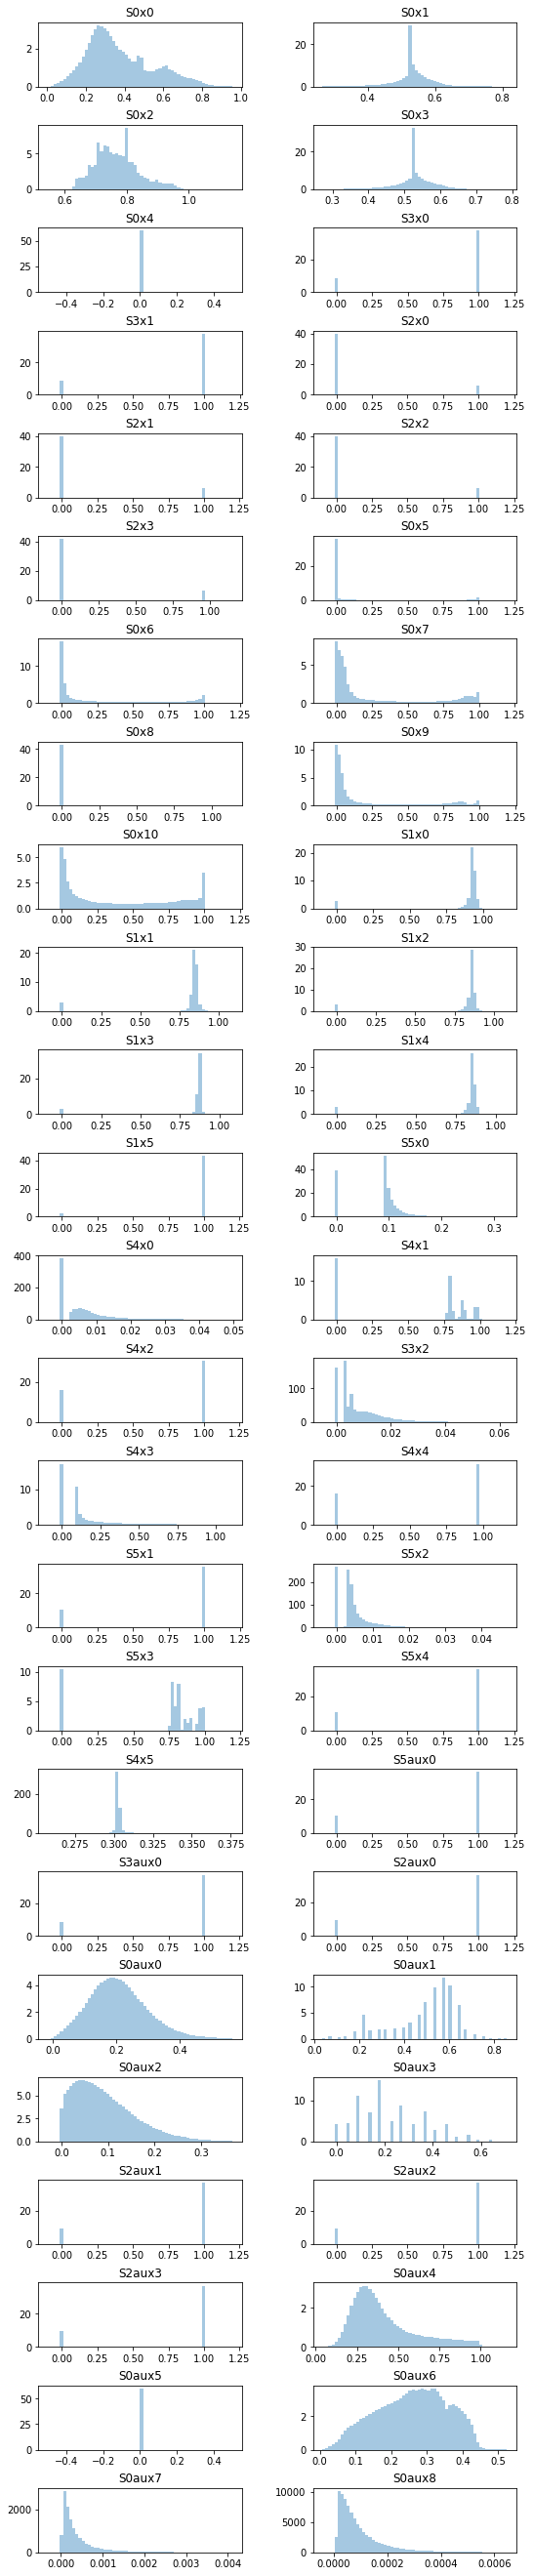

In [26]:
%%time
# Display histograms of our features
print_features_histograms(df_scaled[vars_list_input + vars_list_aux], None, save_filename="./img/scaled_distribs.png")